In [50]:
import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
#import reproject
print(np.__version__)
#import aplpy
import csv
import cmasher as cmr


%config Completer.use_jedi = False
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important}</style>"))


1.21.2


/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/3415778175.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [51]:
path = '/Users/hph/Dropbox/astrophys/CMZoom/cmzoom_catalog/catalog_acc/'
savepath = '/Users/hph/Dropbox/astrophys/CMZoom/SF_tracer_paper/'
catalog = Table.read(path+'catalog_acc.fits')


In [52]:
path = '/Users/hph/Dropbox/astrophys/CMZoom/cmzoom_catalog/catalog_acc/'
catalog = Table.read(path+'megacatalog_acc.fits')
teamcat = Table.read(path+'megacatalog_team_acc_final_say.fits')
#teamcat.keys()

In [53]:
### list of incides to exclude due to proximity to edge
ex_index = np.array([374,1067,3258,4005,20803,21252,21336,22434,22648,22947,23297])
### simultaneously remove sgrb2, sgra*, and edge indices
goodmask = (1-np.isin(teamcat['index'],ex_index)) & (teamcat['mask_num']!=27) & (teamcat['mask_num']!=9)

### define masking conditions for plotting
SF_all_cond = np.where(goodmask)[0]
SF_final_1cond = np.where((teamcat['SF_final_say']==1)&(goodmask))[0]
SF_final_2cond = np.where((teamcat['SF_final_say']==2)&(goodmask))[0]
SF_final_0cond = np.where((teamcat['SF_final_say']==0)&(goodmask))[0]
SF_final_1or2cond = np.where(((teamcat['SF_final_say']==1)|(teamcat['SF_final_say']==2))&(goodmask))[0]

SF_final_1cond_noncmz = np.where((teamcat['SF_final_say']==1)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_0cond_noncmz = np.where((teamcat['SF_final_say']==0)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_2cond_noncmz = np.where((teamcat['SF_final_say']==2)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_allcond_noncmz = np.where((goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]

SF_final_1cond_cmz = np.where((teamcat['SF_final_say']==1)&(goodmask)
                                &((teamcat['mask_num']>7)&(teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]
SF_final_0cond_cmz = np.where((teamcat['SF_final_say']==0)&(goodmask)
                                &((teamcat['mask_num']>7)&(teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]
SF_final_2cond_cmz = np.where((teamcat['SF_final_say']==2)&(goodmask)
                                &((teamcat['mask_num']>7)&(teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]
SF_final_allcond_cmz = np.where((goodmask)
                                &((teamcat['mask_num']>7)&(teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]


In [54]:
print(f'There are {SF_all_cond.shape[0]} leaves in the catalog subsample, excluding Sgr B2, Sgr A* and edge leaves')
print(f'There are {SF_final_allcond_cmz.shape[0]} leaves in CMZ clouds in the catalog subsample')
print(f'There are {SF_final_allcond_noncmz.shape[0]} leaves in non-CMZ clouds in the catalog subsample')
print(f'There are {SF_final_1cond_cmz.shape[0]} robustly starforming leaves in CMZ clouds in the catalog subsample')
print(f'There are {SF_final_1cond_noncmz.shape[0]} robustly starforming leaves in non-CMZ clouds in the catalog subsample')

There are 199 leaves in the catalog subsample, excluding Sgr B2, Sgr A* and edge leaves
There are 168 leaves in CMZ clouds in the catalog subsample
There are 31 leaves in non-CMZ clouds in the catalog subsample
There are 20 robustly starforming leaves in CMZ clouds in the catalog subsample
There are 18 robustly starforming leaves in non-CMZ clouds in the catalog subsample


<IPython.core.display.Javascript object>


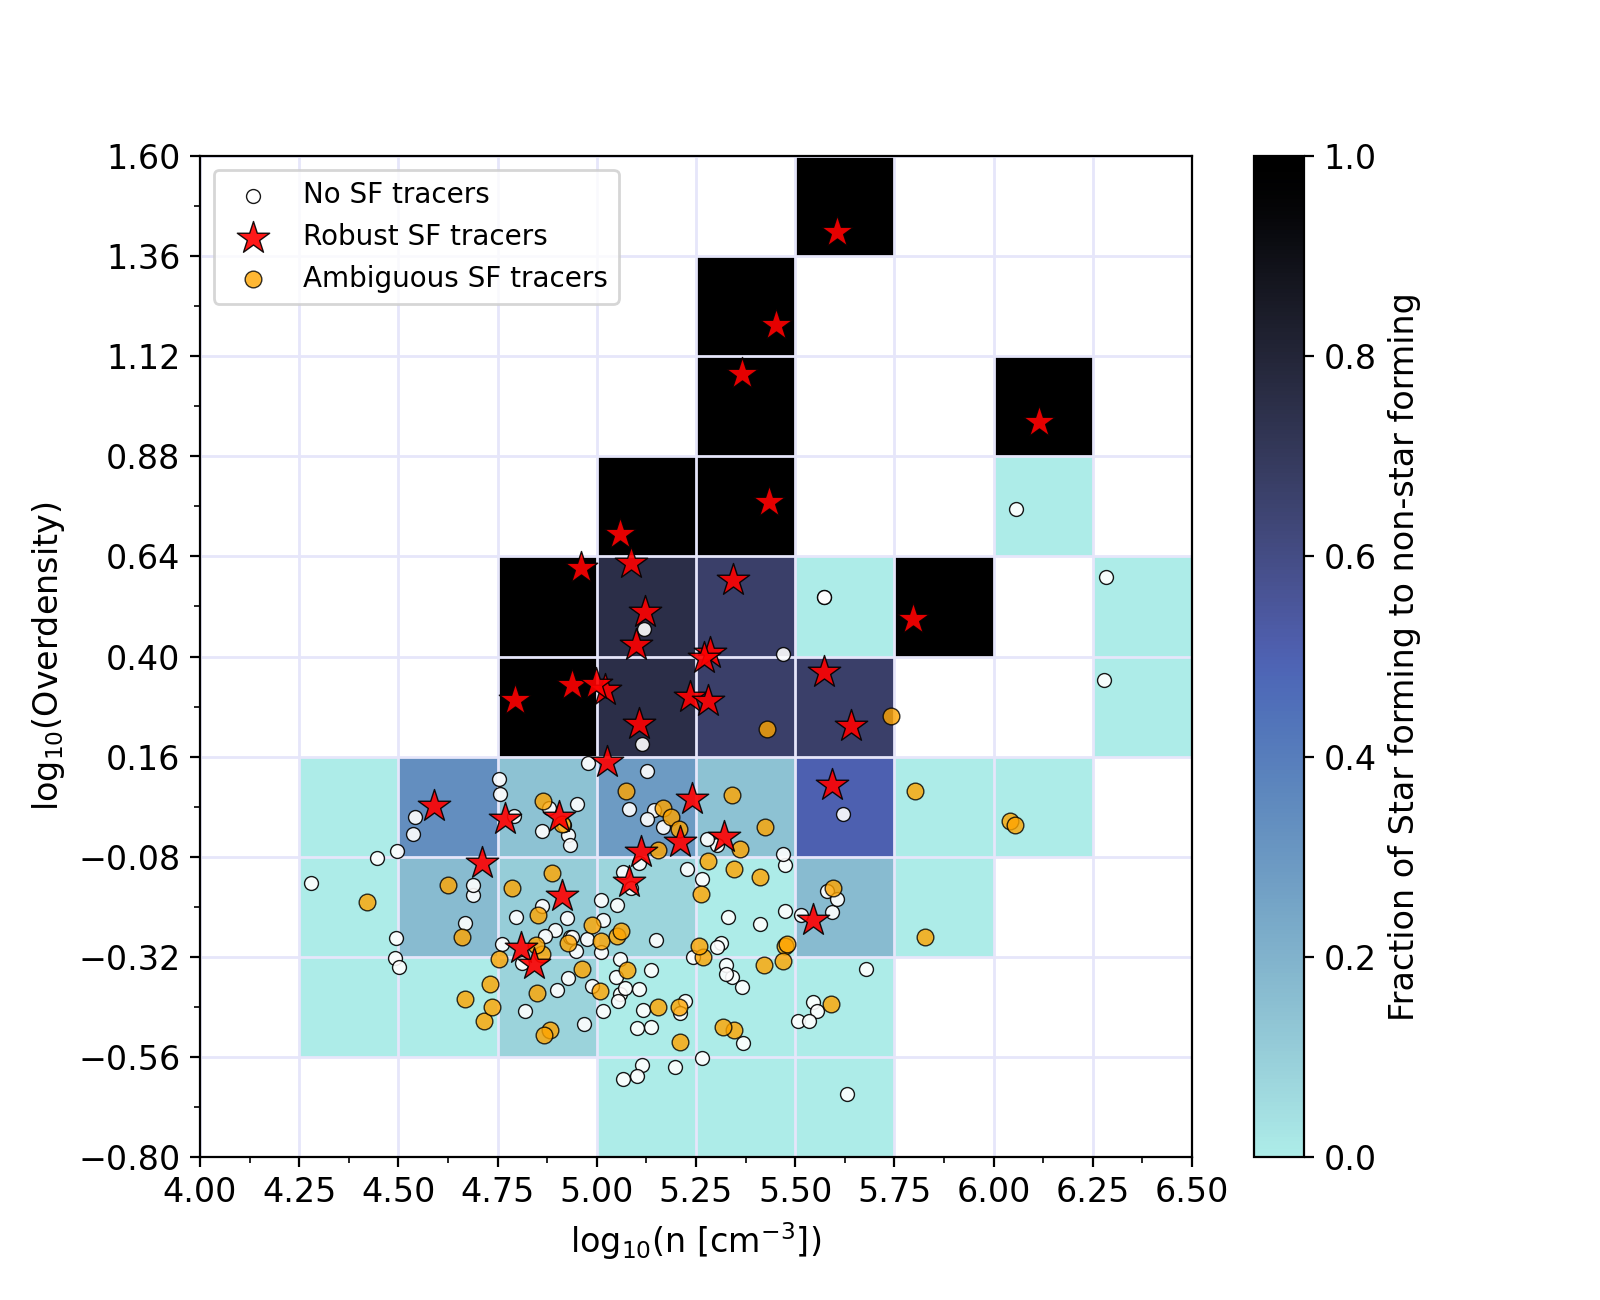

[  10000.           17782.79410039   31622.77660168   56234.13251903
  100000.          177827.94100389  316227.76601684  562341.32519035
 1000000.         1778279.41003892 3162277.66016838]


In [55]:
#############################
### scatter plot as 2d Hist?
#############################

plt.rcParams.update({'font.size': 12})
q1 = 'n' ### y axis
catq1 = teamcat['n']#/catalog['herschel_column']
q2 = 'overdensity' ### x axis
catq2 = teamcat['sma_column']/teamcat['herschel_column']
starcond = SF_final_1cond
nostarcond = SF_final_0cond
maybestarcond = SF_final_2cond
allcond = SF_all_cond

fig,ax = plt.subplots(figsize=(8, 6.5))

xmin,xmax = 4.0,6.5
ymin,ymax = -0.8,1.6
odbins = np.logspace(ymin,ymax,11)
nbins = np.logspace(xmin,xmax,11)
binsx1 = nbins #np.logspace(np.log10(catq1[allcond].min()),np.log10(catq1[allcond].max()),10)
binsy1 = odbins #np.logspace(np.log10(catq2[allcond].min()),np.log10(catq2[allcond].max()),10)
hist_sf, esf1, esf2 = np.histogram2d(x=catq1[starcond],y=catq2[starcond],bins=[binsx1,binsy1])

hist_all, eall1, eall2 = np.histogram2d(x=catq1[allcond],y=catq2[allcond],bins=[binsx1,binsy1])

hist_all[hist_all==0]=np.nan
#hist_sf[hist_sf==0]=np.nan

hist_ratio = hist_sf/hist_all
#hist_ratio[np.isnan(hist_ratio)]=0
current_cmap = plt.cm.get_cmap('Greys').copy()
current_cmap = cmr.sapphire_r
current_cmap.set_bad(color='w')
im=ax.imshow(hist_ratio.T, vmax=1.0,vmin=0.0,
             extent=[xmin,xmax,ymin,ymax],
             aspect="auto",origin='lower',cmap=current_cmap)

cbar = plt.colorbar(im)
cbar.set_label('Fraction of Star forming to non-star forming')

# ax.scatter(np.log10(catq2[starcond]), np.log10(catq1[starcond]),
#                  color='red',alpha=0.8,marker='*',label='leaves with a robust SF tracer')
# ax.scatter(np.log10(catq2[nostarcond]), np.log10(catq1[nostarcond]),
#                   color='cornflowerblue',alpha=0.4,label='all other leaves')

ax.set_ylabel('log$_{10}$(Overdensity)')
ax.set_xlabel('log$_{10}$(n [cm$^{-3}$])')
#ax.set_xlim(np.log10(binsx1[0]),np.log10(binsx1[7]))
#ax.set_ylim(np.log10(binsy1[0]),np.log10(binsy1[2]))
ax.set_xticks(np.log10(binsx1),minor=False)
ax.set_yticks(np.log10(binsy1),minor=False)
bwx = 0.5*(np.log10(binsx1[1])-np.log10(binsx1[0]))
bwy = 0.5*(np.log10(binsy1[1])-np.log10(binsy1[0]))
ax.set_xticks(np.log10(binsx1[0:-1])+bwx, minor=True)
ax.set_yticks(np.log10(binsy1[0:-1])+bwy, minor=True)
ax.grid(which='major', color='lavender', linestyle='-', linewidth=1.0,zorder=1)
#ax.grid()

ax.scatter(np.log10(catq1[nostarcond]), np.log10(catq2[nostarcond]), s = 25, linewidth=0.5,
                  color='k',facecolor='w',alpha=0.9,label='No SF tracers',zorder=3)
ax.scatter(np.log10(catq1[starcond]), np.log10(catq2[starcond]), s=150., linewidth=0.5,zorder=5,
                 color='k',facecolor='r',alpha=0.9,marker='*',label='Robust SF tracers')
ax.scatter(np.log10(catq1[maybestarcond]), np.log10(catq2[maybestarcond]), marker='o',linewidth=0.5,
                  color='k',facecolor='orange',alpha=0.8,label='Ambiguous SF tracers',zorder=4)

ax.legend(loc='upper left',fontsize=10)

print(esf1)
plt.savefig(savepath+'scatterhist_od_vs_n.pdf',dpi=200,bbox_inches='tight')


<IPython.core.display.Javascript object>


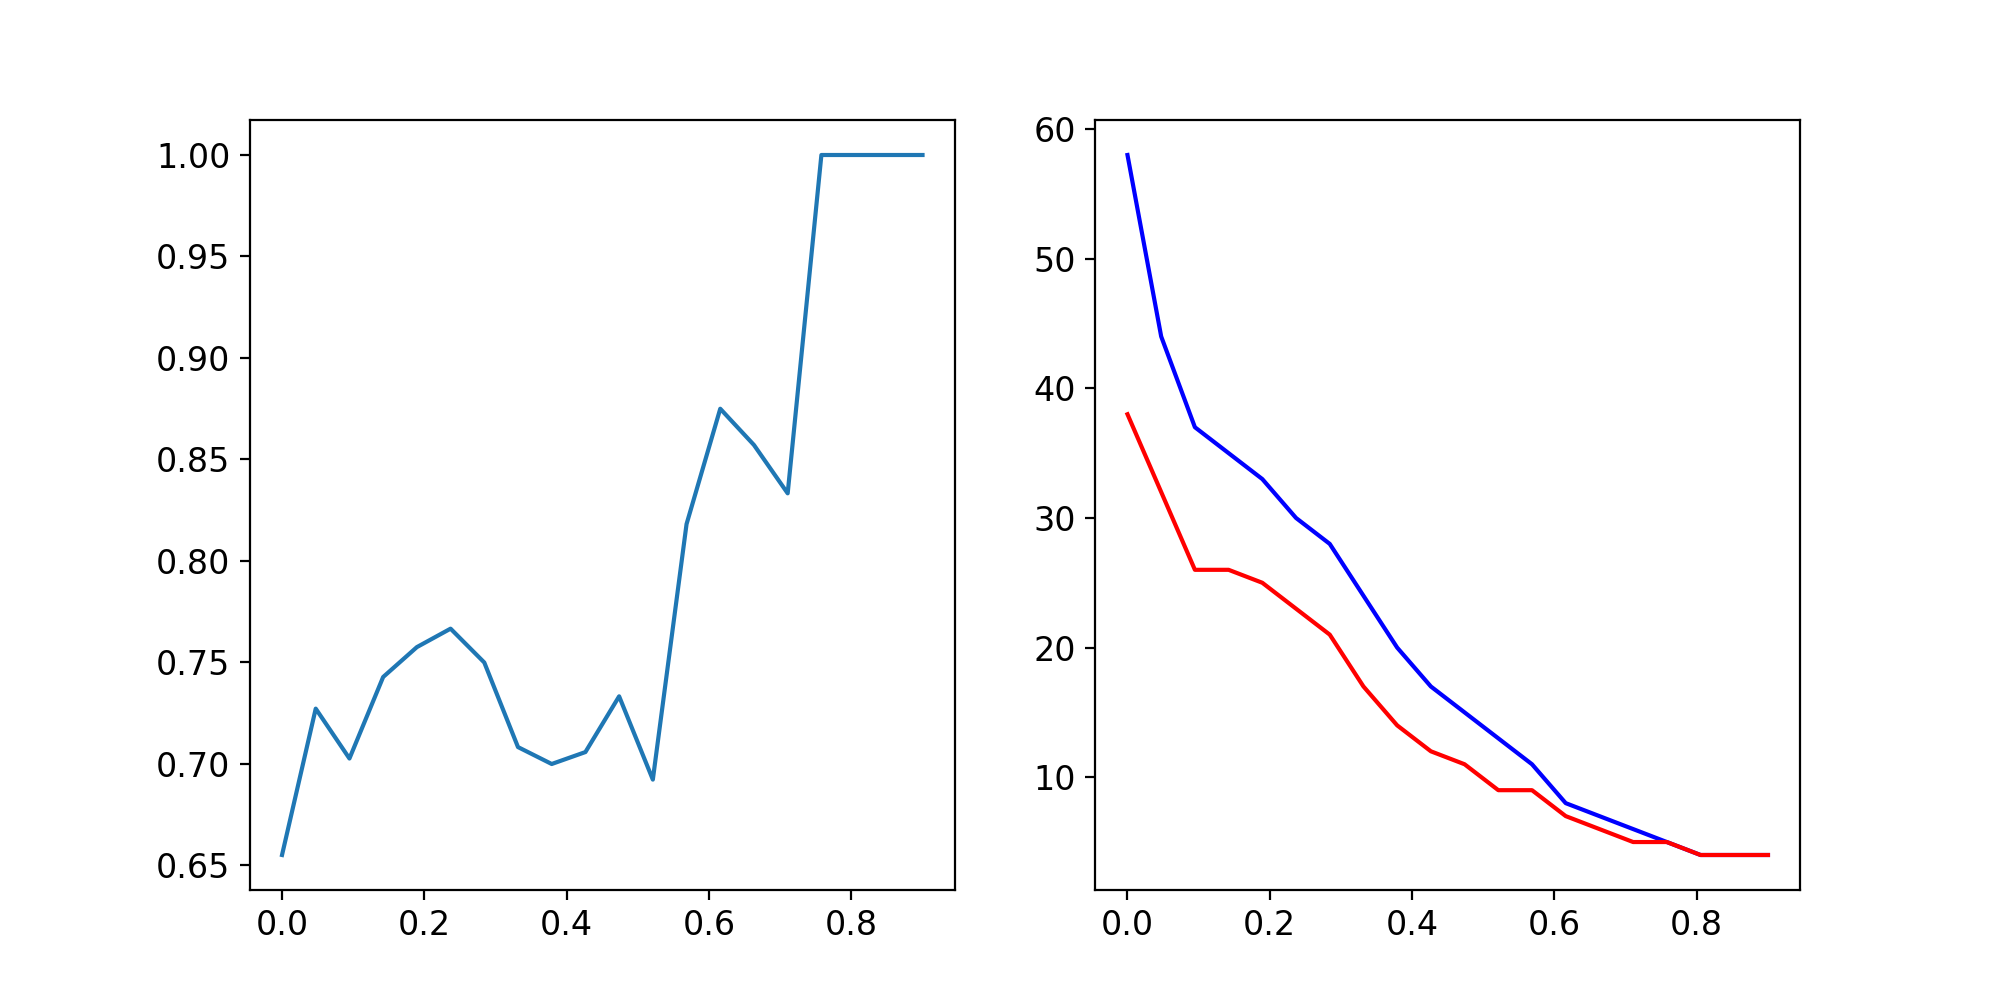

In [61]:
### calculate the number / fraction of star forming leaves above 1.4 overdensity
### 

od = teamcat['sma_column']/teamcat['herschel_column']
od_arr = np.linspace(0.00,0.9,20)
od_frac_arr = np.zeros_like(od_arr)
od_num_arr = np.zeros_like(od_arr)
od_num_SF_arr = np.zeros_like(od_arr)
for i,od_cut in enumerate(od_arr):
    od_frac_arr[i] = len(np.where((np.log10(od[SF_final_1or2cond])>od_cut))[0]) / len(np.where(np.log10(od[allcond])>od_cut)[0])
    od_num_arr[i] = len(np.where(np.log10(od[allcond])>od_cut)[0])
    od_num_SF_arr[i] = len(np.where((np.log10(od[SF_final_1or2cond])>od_cut))[0])
fig, axes = plt.subplots(nrows = 1, ncols=2,figsize=(10,5))
ax = axes[0]
ax.plot(od_arr,od_frac_arr)

ax = axes[1]
ax.plot(od_arr, od_num_arr,color='b')
ax.plot(od_arr, od_num_SF_arr, color='r')



<IPython.core.display.Javascript object>


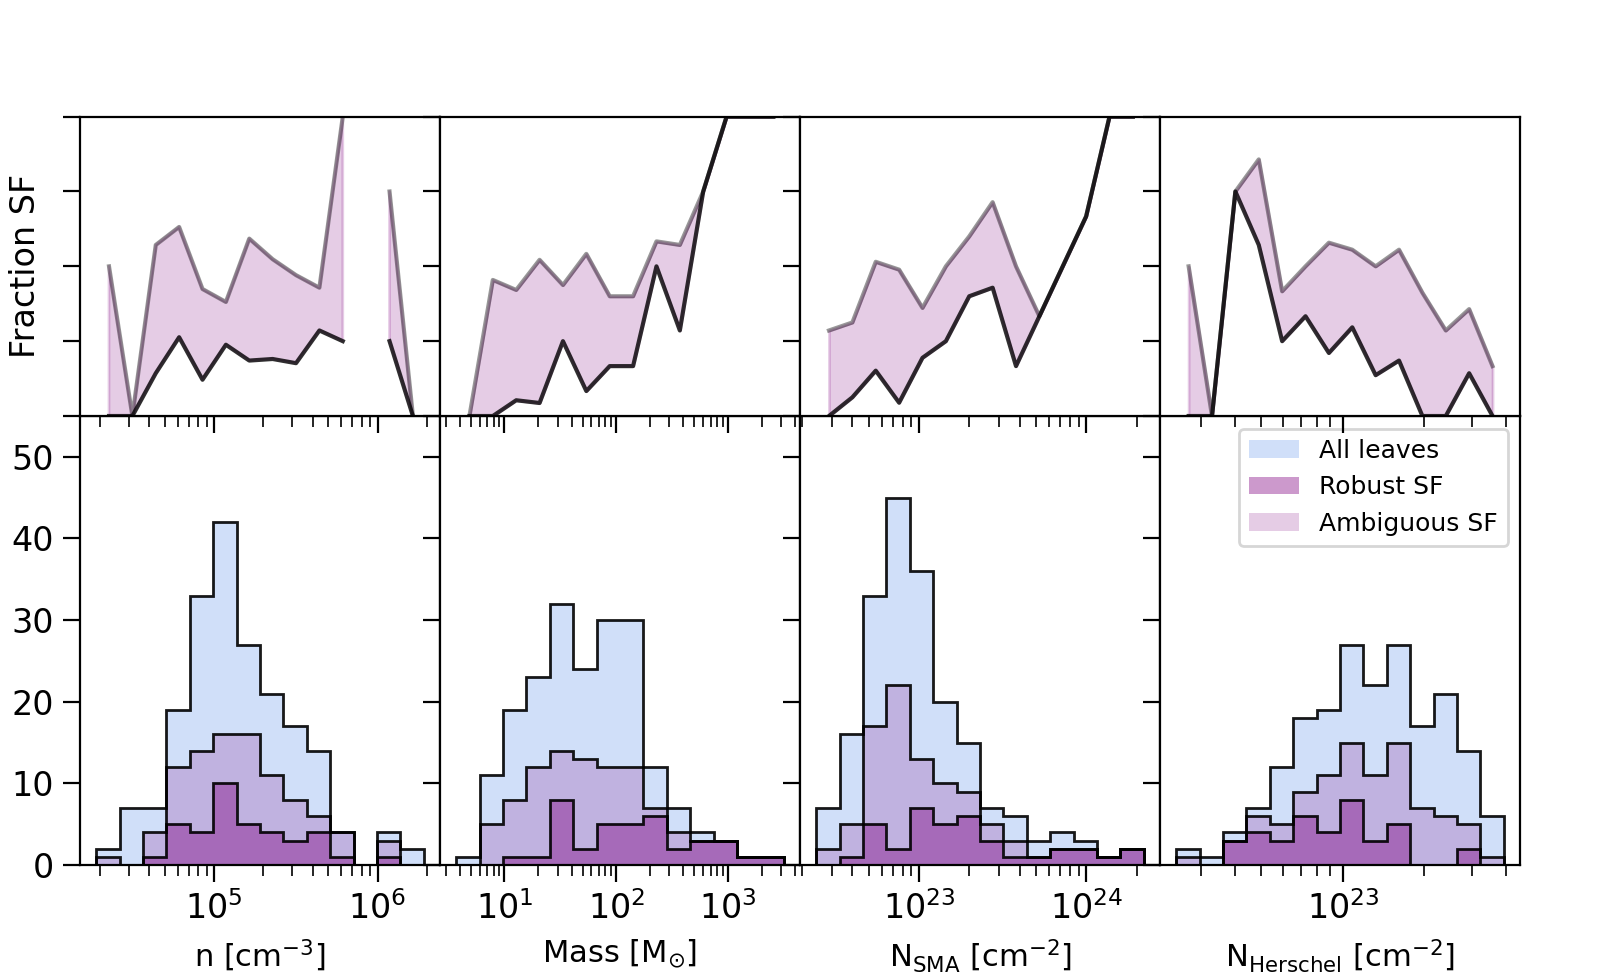

/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/703187205.py:54: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/703187205.py:55: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/703187205.py:56: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/703187205.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [57]:
##################################################################
### 4 and 4 panel histograms, separate range between robust and ambiguous
##################################################################
### multi panel histograms
fig = plt.figure(constrained_layout=False,figsize=(8,4))
gs1 = fig.add_gridspec(nrows=5, ncols=4, left=0.05, right=0.95,
                        wspace=0.00,hspace=0.0)

cond12 = SF_final_1or2cond
cond1 = SF_final_1cond
acond = SF_all_cond

binnum = 15

################################################################### 

### NUMBER DENSITY
ax = fig.add_subplot(gs1[2:,0])
quantity = catalog['n']

logbins = np.logspace(np.log10(min(quantity[acond])),np.log10(max(quantity[acond])),binnum)
bincens = logbins.copy()

h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Leaves with SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Leaves with SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

#ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.set_xscale('log')
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,0])
ax2.set_xscale('log')
ax2.set_ylim(0,55)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([])

for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax2.set_yticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
ax.set_xlabel("n [cm$^{-3}$]",fontsize=11)
ax.set_ylabel("Number of Leaves",fontsize=11)
ax2.set_ylabel('Fraction SF')

#######################################################################

### MASS
ax = fig.add_subplot(gs1[2:,1])
quantity = catalog['mass']

logbins = np.logspace(np.log10(min(quantity[acond])),np.log10(max(quantity[acond])),binnum)
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Robust SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Ambiguous SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.set_xscale('log')
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,1])
ax2.set_ylim(0,55)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax2.set_yticklabels([])
ax.set_xlabel("Mass [M$_{\odot}]$",fontsize=11)

#########################################################################

### SMA COLUMN
ax = fig.add_subplot(gs1[2:,2])

quantity = catalog['sma_column']
logbins = np.logspace(np.log10(min(quantity[acond])),np.log10(max(quantity[acond])),binnum)
bincens = logbins.copy()
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Robust SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Ambiguous SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_xscale('log')
ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,2])
ax2.set_xscale('log')
ax2.set_ylim(0,55)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([])

for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax2.set_yticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
ax.set_xlabel("N$_{\\rm SMA}$ [cm$^{-2}$]",fontsize=11)

###################################################################################################

### HERSCHEL COLUMN
ax = fig.add_subplot(gs1[2:,3])

quantity = catalog['herschel_column']

logbins = np.logspace(np.log10(min(quantity[acond])),np.log10(max(quantity[acond])),binnum)
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Robust SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Ambiguous SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_xscale('log')
ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,3])
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax.set_yticklabels([])
ax.set_xlabel("N$_{\\rm Herschel}$ [cm$^{-2}$]",fontsize=11)
plt.tight_layout()

plt.savefig(savepath+'final_sf_prop_hist_multipanel_4and4_1.pdf',dpi=300,bbox_inches='tight')


<IPython.core.display.Javascript object>


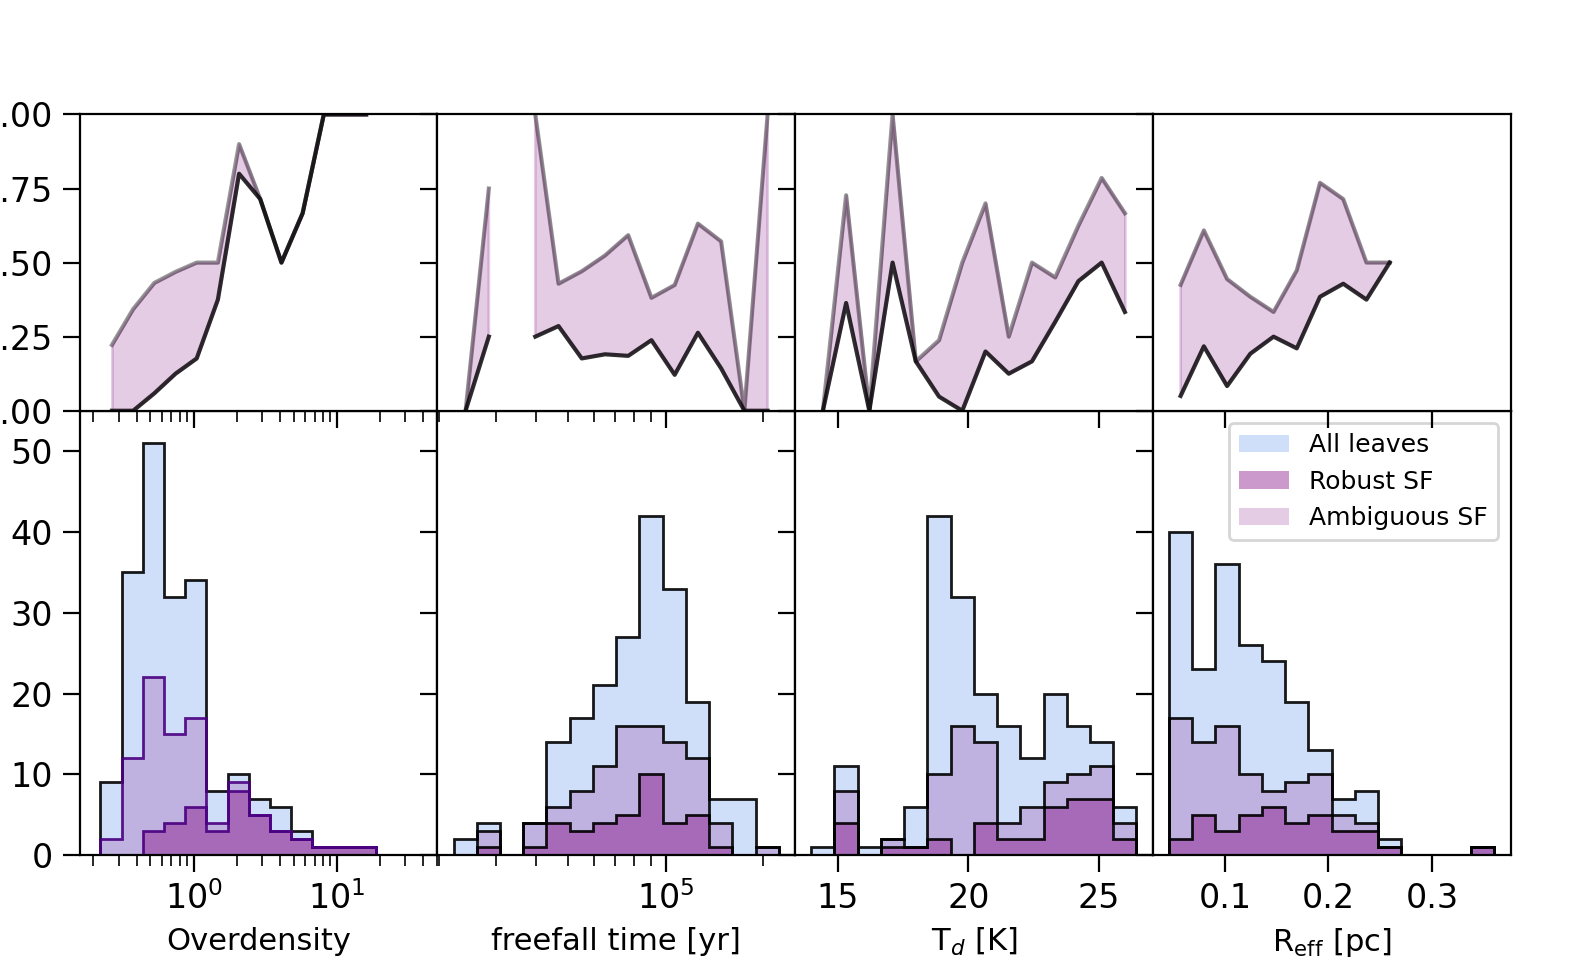

/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/1816545944.py:49: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/1816545944.py:50: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/1816545944.py:51: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/1816545944.py:94: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_4794/1816545944.py:95: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
/var/folders/5j/kk60b8j15

In [58]:
##################################################################
### 4 and 4 panel histograms, separate range between robust and ambiguous
##################################################################
### multi panel histograms
fig = plt.figure(constrained_layout=False,figsize=(8,4))
gs1 = fig.add_gridspec(nrows=5, ncols=4, left=0.05, right=0.95,
                        wspace=0.00,hspace=0.0)

cond12 = SF_final_1or2cond
cond1 = SF_final_1cond
acond = SF_all_cond

### OVERDENSITY
ax = fig.add_subplot(gs1[2:,0])
overdensity = catalog['sma_column']/catalog['herschel_column']
logbins = np.logspace(np.log10(min(overdensity[acond])),np.log10(max(overdensity[acond])),binnum)
h1,l1,e1 = ax.hist(overdensity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(overdensity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(overdensity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Robust SF')
h2,l2,e2 = ax.hist(overdensity[cond1],log=False,bins=logbins,
                   color='indigo',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(overdensity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Ambiguous SF')
h3,l3,e3 = ax.hist(overdensity[cond12],log=False,bins=logbins,
                   color='indigo',alpha=0.9,histtype='step')

ax.set_xscale('log')
ax.set_xlim(0.16,50)
ax.set_ylim(0,55)
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,0])
ax2.set_xscale('log')
ax2.set_xlim(0.16,50)
ax2.set_ylabel('Fraction SF')
ax2.set_xticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
bincens = logbins.copy()
for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax.set_xlabel("Overdensity",fontsize=11)
ax.set_ylabel("Number of Leaves",fontsize=11)

#######################################################################
### FREEFALL TIME
ax = fig.add_subplot(gs1[2:,1])

quantity = catalog['tff']

logbins = np.logspace(np.log10(min(quantity[acond])),np.log10(max(quantity[acond])),binnum)
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='purple',alpha=0.4,label='Leaves with SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='purple',alpha=0.2,label='Leaves with SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=logbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.set_xscale('log')
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,1])
ax2.set_ylim(0,55)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
for i in range(len(logbins)-1):
    bincens[i]=(logbins[i+1]+logbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax2.set_yticklabels([])
ax.set_xlabel("freefall time [yr]",fontsize=11)

#ax.set_ylabel("Number")
#ax2.set_ylabel('Fraction of leaves with SF')
#ax.legend(loc='upper left')

### DUST TEMPERATURE
ax = fig.add_subplot(gs1[2:,2])
quantity = catalog['DustTemperature']

linbins = np.linspace(min(quantity[acond]),max(quantity[acond]),binnum)
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=linbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=linbins,
                   color='purple',alpha=0.4,label='Leaves with SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=linbins,
                   color='purple',alpha=0.2,label='Leaves with SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_xscale('linear')
ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
#ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,2])
ax2.set_xscale('linear')
ax2.set_ylim(0,55)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([])

for i in range(len(linbins)-1):
    bincens[i]=(linbins[i+1]+linbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax2.set_yticklabels([])
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
ax.set_xlabel("T$_d$ [K]",fontsize=11)

#######################################################################

## EFFECTIVE RADIUS
ax = fig.add_subplot(gs1[2:,3])
quantity = catalog['r_eff_pc']

linbins = np.linspace(min(quantity[acond]),max(quantity[acond]),binnum)
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=linbins,
                   color='cornflowerblue',alpha=0.3,label='All leaves')
h1,l1,e1 = ax.hist(quantity[acond],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=linbins,
                   color='purple',alpha=0.4,label='Robust SF')
h2,l2,e2 = ax.hist(quantity[cond1],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=linbins,
                   color='purple',alpha=0.2,label='Ambiguous SF')
h3,l3,e3 = ax.hist(quantity[cond12],log=False,bins=linbins,
                   color='k',alpha=0.9,histtype='step')

ax.set_xscale('linear')
ax.set_yticklabels([])
ax.set_ylim(0,55)
ax.tick_params(length=6,which='major',axis='both',direction='out')
ax.tick_params(length=4,which='minor',axis='both',direction='out')
ax.legend(loc='upper right',fontsize=9)

ax2 = fig.add_subplot(gs1[0:2,3])
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('linear')
ax2.tick_params(length=6,which='major',axis='both',direction='out')
ax2.tick_params(length=4,which='minor',axis='both',direction='out')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
for i in range(len(linbins)-1):
    bincens[i]=(linbins[i+1]+linbins[i])/2.
ax2.plot(bincens[:-1],h2/h1,color='k',alpha=0.8)
ax2.plot(bincens[:-1],h3/h1,color='k',alpha=0.4)
ax2.fill_between(bincens[:-1],y1=h2/h1,y2=h3/h1,color='purple',alpha=0.2)
ax2.set_ylim(0,1)
ax.set_yticklabels([])
ax.set_xlabel("R$_{\\rm eff}$ [pc]",fontsize=11)
plt.tight_layout()

plt.savefig(savepath+'final_sf_prop_hist_multipanel_4and4_2.pdf',dpi=300,bbox_inches='tight')
